In [22]:
import sys
sys.path.append('..')
from data_utils import *

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

In [23]:
# Loading in data
load_wfs = np.load('random_100k.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.05
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)
    waveforms = waveforms.unsqueeze(1)  # adding channel dimension

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    
    return waveforms, arrival_times, hit_times
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (85000, 10000, 5000)


torch.Size([25, 1, 1000])
torch.Size([25, 1, 1000])


Text(0.5, 1.0, 'Waveform & Hit Time')

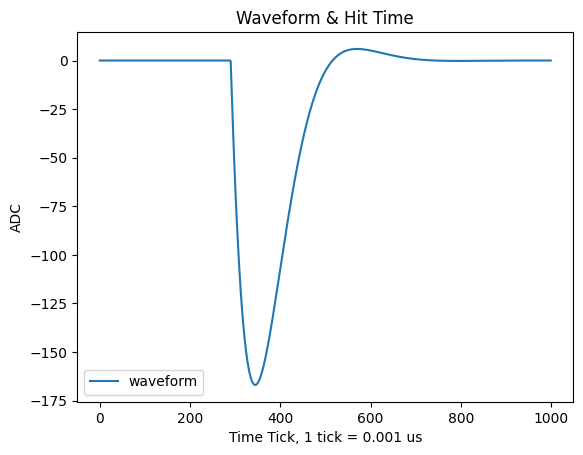

In [24]:
waveforms, arrival_times, hit_times = next(iter(train_loader))
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[1].shape[1])

for i, wf in enumerate(waveforms):
    plt.plot(ticks, wf.squeeze(0), alpha=1, label='waveform')
    arrival_idx = torch.nonzero(arrival_times[i].squeeze(0), as_tuple=False).squeeze().item()
    # plt.axvline(x=arrival_idx, color='r', linestyle='--', linewidth=4, label='True arrival')
    break

plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
# plt.title(f"Batch of {len(waveforms)} 1D Waveforms")
plt.title("Waveform & Hit Time")

In [25]:
# Doing the training yuhh
from model import *
from utils import *
import torch.optim as optim
import wandb

epochs = 50
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="transformer-bin-precision",
    name="50_epochs",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = Transformers2()
model.to(device)
wandb.watch(model, log="all", log_freq=100)

# criterion = torch.nn.BCEWithLogitsLoss() # combines sigmoid + loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

mode = 'mined_bce'
results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, epochs, mode, logger)
# wandb.finish()
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "bigtrans_bin_precision_50epochs.pth")

epoch,▂▂▃▃▄▆▇▇█▂▃▃▃▅▅▆▇▇█▁▂▂▃▄▄▅▆▇▇▇▁▂▃▃▄▅▆▆▆▇
eval_acc,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▅▇▇▇▇▇█▇███████████████
eval_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇█████████████
train_loss,█▇▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
eval_acc,0.75083
eval_loss,0.03949
train_acc,0.76294
train_loss,0.01147


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
                                                                                                     

KeyboardInterrupt: 

In [26]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "bigtrans_bin_precision_40epochs.pth")

In [6]:
# Instantiating from a Checkpoint
checkpoint = torch.load("trans_bin_precision_50epochs.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = 50 + 1

more_epochs = 50
more_results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, more_epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "trans_bin_precision_100epochs.pth")

/lscratch/carsmith/tmp/ipykernel_3658586/3202653925.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("trans_bin_precision_50epochs.pth")
         

In [7]:
# Instantiating from a Checkpoint
checkpoint = torch.load("trans_bin_precision_100epochs.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = 100 + 1

more_epochs = 50
results_150 = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, more_epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "trans_bin_precision_150epochs.pth")

/lscratch/carsmith/tmp/ipykernel_3658586/1909705439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("trans_bin_precision_100epochs.pth")
        

In [13]:
# Instantiating from a Checkpoint
checkpoint = torch.load("trans_bin_precision_150epochs.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = 150 + 1

more_epochs = 50
results_200 = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, more_epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, "trans_bin_precision_200epochs.pth")

/lscratch/carsmith/tmp/ipykernel_3658586/3676830319.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("trans_bin_precision_150epochs.pth")
        

In [19]:
with open("results_transbinprecision200epochs.pkl", "rb") as f:
    all_results = pickle.load(f)
# all_results = {
#     k: np.concatenate([loaded_results[k], results_200[k]])
#     for k in results
# }

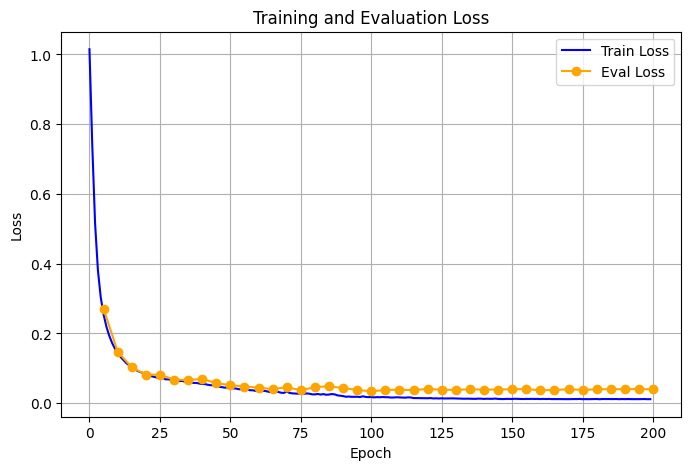

In [20]:
plt.figure(figsize=(8, 5))

# Plot training loss (one per epoch)
plt.plot(all_results['train_loss'], label='Train Loss', color='blue')

# Plot eval loss (every 5 epochs)
eval_epochs = np.arange(0, len(all_results['train_loss']), 5)
plt.plot(eval_epochs + 5, all_results['eval_loss'], marker='o', label='Eval Loss', color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

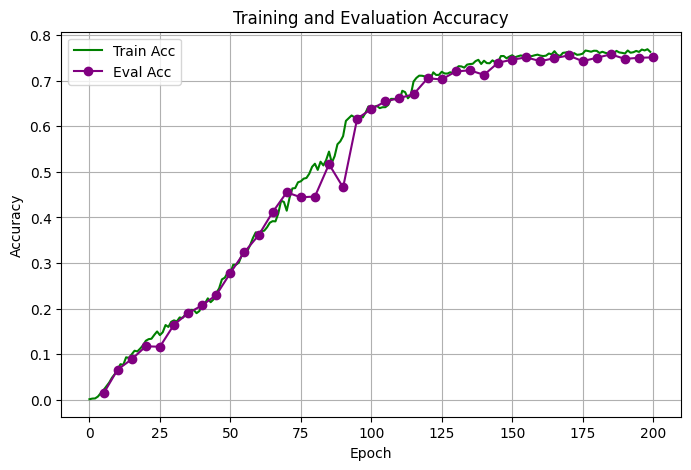

In [21]:
plt.figure(figsize=(8, 5))

# Plot training loss (one per epoch)
plt.plot(all_results['train_acc'], label='Train Acc', color='green')

# Plot eval loss (every 5 epochs)
eval_epochs = np.arange(0, len(all_results['train_acc']), 5)
plt.plot(eval_epochs + 5, all_results['eval_acc'], marker='o', label='Eval Acc', color='purple')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Evaluation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Inspecting Sampled Bins
plt.figure(figsize=(15, 5))
plt.plot(masked_target[152:305].cpu(), marker='o', label='target')
plt.plot(torch.sigmoid(masked_output[152:305]).detach().cpu(), marker='o', label='pred w/ sigmoid')

true_idx = torch.where(masked_target[152:305].cpu() == 1.0)[0].item()
plt.axvline(true_idx, color='red', linestyle='--', linewidth=3, label='true hit')
plt.axvspan(true_idx, true_idx+50, color='red', alpha=0.1, label='within 250 ns of hit')

indices = torch.nonzero(sampled_indices.cpu()[0] == True).squeeze().tolist()
plt.xticks(ticks=range(len(indices)), labels=indices)

plt.xlabel('sampled bins from one time window')
plt.ylabel('value')
plt.title('151 Sampled Bins For 1 Time Window')
plt.legend()
plt.show()

NameError: name 'masked_target' is not defined

<Figure size 1500x500 with 0 Axes>

In [12]:
# Plotting regression output
train_progress = tqdm(val_loader, leave=False, position=0)
for i, (data, target, hit_times) in enumerate(train_progress):
    data, target, hit_times = data.to(device), target.to(device), hit_times.to(device) # data and target [B, 1, 16000], hit_times [B, 1]
    output = model(data)
    break

acc, output_batch, gt_indices_batch, pred_batch  = val_regression(data, hit_times, output, device)

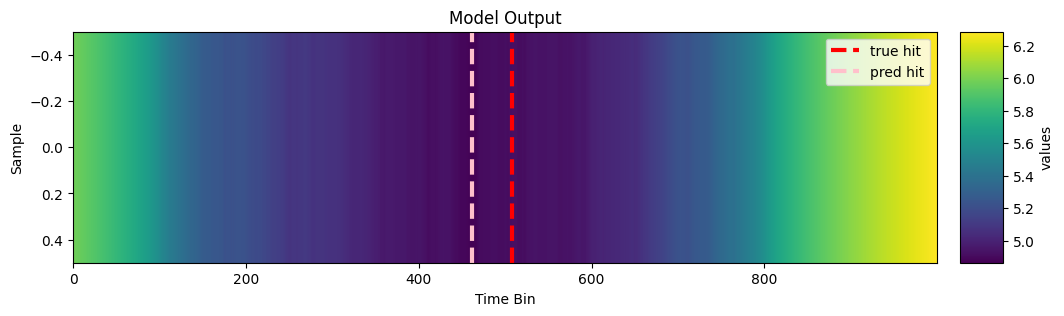

In [13]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space

ax1 = fig.add_subplot(gs[0])
heatmap = output_batch.unsqueeze(0).detach().cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

# Vertical lines at near-zero bins
for idx in gt_indices_batch:
    ax1.axvline(idx.cpu(), color='red', linestyle='--', linewidth=3, label='true hit')

for idx in pred_batch:
    ax1.axvline(idx.cpu(), color='pink', linestyle='--', linewidth=3, label='pred hit')
# Labels and title
ax1.legend()
ax1.set_title("Model Output")
ax1.set_xlabel("Time Bin") 
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
fig.colorbar(im, cax=cax, orientation='vertical', label='values')
plt.show()

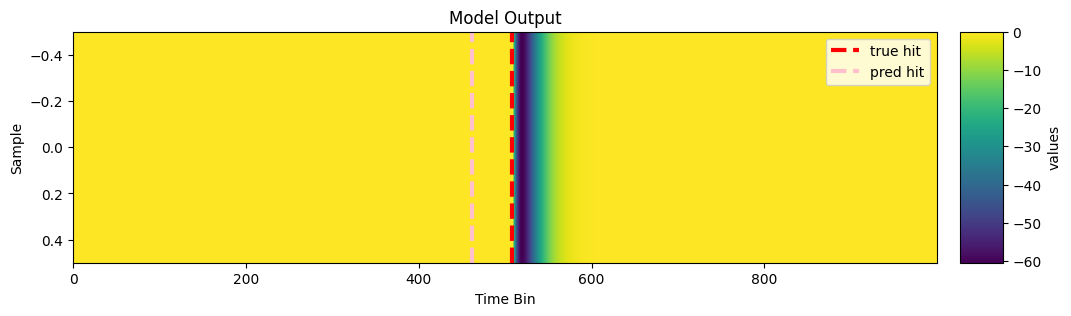

In [17]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)  # allocate space

ax1 = fig.add_subplot(gs[0])
heatmap = data[-1].detach().cpu().numpy()
im = ax1.imshow(heatmap, aspect='auto', cmap='viridis')

# Vertical lines at near-zero bins
for idx in gt_indices_batch:
    ax1.axvline(idx.cpu(), color='red', linestyle='--', linewidth=3, label='true hit')

for idx in pred_batch:
    ax1.axvline(idx.cpu(), color='pink', linestyle='--', linewidth=3, label='pred hit')
# Labels and title
ax1.legend()
ax1.set_title("Model Output")
ax1.set_xlabel("Time Bin") 
ax1.set_ylabel("Sample")

# Add colorbar on the right
cax = fig.add_subplot(gs[1])  # colorbar axis
fig.colorbar(im, cax=cax, orientation='vertical', label='values')
plt.show()